Explain how to read a geotiff file and display it using matplotlib.

In [1]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import subprocess

## 1. No need for new projection

In [7]:
imagefile = "/data/Visible/VIIRS_20170902.tiff"
imagefile = "/home/ctroupin/Presentations/PresentationsHTML/images/Phidias/stareso_sentinel-2_L1C_2019-07-26.tiff"

In [3]:
def read_geotiff(imagefile):
    
    gtif = gdal.Open(imagefile)
    # info about the projection
    arr = gtif.ReadAsArray()
    trans = gtif.GetGeoTransform()
    extent = (trans[0], trans[0] + gtif.RasterXSize*trans[1],
              trans[3] + gtif.RasterYSize*trans[5], trans[3])
    # Permute dimensions
    arr = np.transpose(arr, (1, 2, 0))

    x = np.arange(0, gtif.RasterXSize)
    y = np.arange(0, gtif.RasterYSize)
    xx, yy = np.meshgrid(x, y)

    lon = trans[1] * xx + trans[2] * yy + trans[0]
    lat = trans[4] * xx + trans[5] * yy + trans[3]
        
    
    return lon, lat, arr, extent

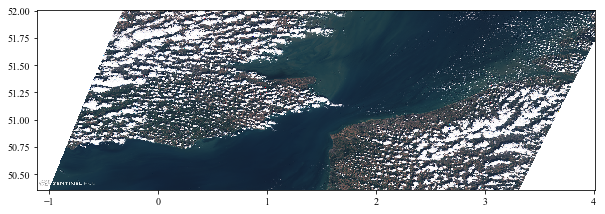

In [4]:
lon, lat, arr, extent = read_geotiff(imagefile)
plt.figure(figsize=(10, 10))
plt.imshow(arr, extent=extent)
plt.show()

In [8]:
lon, lat, arr, extent = read_geotiff(imagefile)
"[{}, {}], [{}, {}]".format(lat.min(), lon.min(), lat.max(), lon.max())

'[42.54663665952421, 8.65851402282715], [42.606989849456795, 8.818408600007647]'

## 2. When change of projection is needed

In [33]:
datadir = "/home/ctroupin/Projects/RandoGC/Data/136_MDT25_GC/"
datafile2 = os.path.join(datadir, '136_MDT25_GC.tif')

In [36]:
def read_geotiff2(filename):
    
    # Create temporaty file
    fd, path = tempfile.mkstemp()
    try:
        with os.fdopen(fd, 'w') as tmp:
            # Transform to lon, lat coordinates using WGS84
            command = 'gdalwarp {} {} -t_srs "+proj=longlat +ellps=WGS84"'.format(path, filename)
            # subprocess.call()
            subprocess.run(command, cwd=datadir, stdout=subprocess.PIPE, shell=True)
            ds = gdal.Open(os.path.join(datadir, 'outfile.tif'), gdal.GA_ReadOnly)
            ds.GetProjectionRef()
            # Read the array and the transformation
            arr = ds.ReadAsArray()
            trans = ds.GetGeoTransform()
            extent = (trans[0], trans[0] + ds.RasterXSize*trans[1],
            trans[3] + ds.RasterYSize*trans[5], trans[3])

            x = np.arange(0, ds.RasterXSize)
            y = np.arange(0, ds.RasterYSize)
    finally:
        os.remove(path)
        
    xx, yy = np.meshgrid(x, y)

    lon = trans[1] * xx + trans[2] * yy + trans[0]
    lat = trans[4] * xx + trans[5] * yy + trans[3]
        
    return lon, lat, arr, extent

In [44]:
lon2, lat2, arr2, extent2 = read_geotiff2(datafile2)

(1944, 2082)

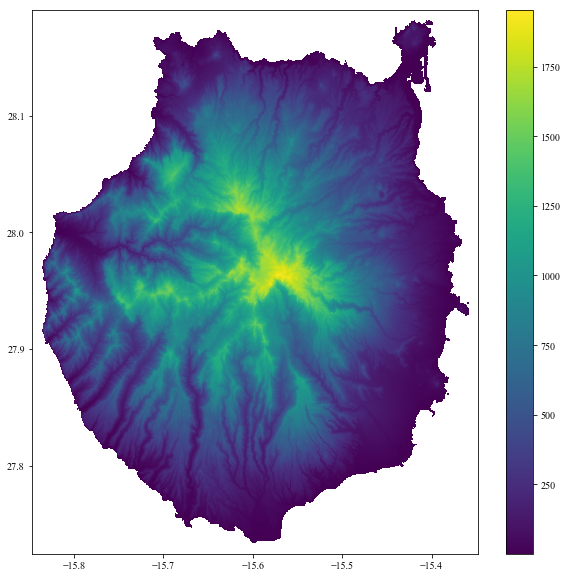

In [42]:
plt.figure(figsize=(10, 10))
arr2 = np.ma.masked_less_equal(arr2, 0.)
plt.pcolormesh(lon2, lat2, arr2)
plt.colorbar()
plt.show()